In [128]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import json

In [129]:
DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion-features-1-1097.sqlite'
CONV_DB_NAME = '/home/ubuntu/UPS2_allion/UPS2_allion.sqlite'
FEATURE_ID = 23
BASE_PEAK_ID = 2
MAX_RT_DISTANCE = 2
MAX_SCAN_DISTANCE = 5
MAX_NUMBER_OF_PEAKS = 20

In [130]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_summed_ms2_regions_1 ON summed_ms2_regions (feature_id, peak_id)")
db_conn.close()

In [131]:
db_conn = sqlite3.connect(DB_NAME)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_ms2_peaks_2 ON ms2_peaks (feature_id, peak_id)")
db_conn.close()

In [132]:
# Load the peak points for the best CofM-matching peaks for this feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peak_points_df = pd.read_sql_query("select peak_id,mz,scan,intensity from summed_ms2_regions where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, MAX_NUMBER_OF_PEAKS), db_conn)
db_conn.close()

In [133]:
# load the feature's base peak points
db_conn = sqlite3.connect(DB_NAME)
base_peak_points_df = pd.read_sql_query("select point_id,mz,scan,intensity from summed_ms1_regions where feature_id={} and peak_id={}".format(FEATURE_ID, BASE_PEAK_ID), db_conn)
db_conn.close()

In [134]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

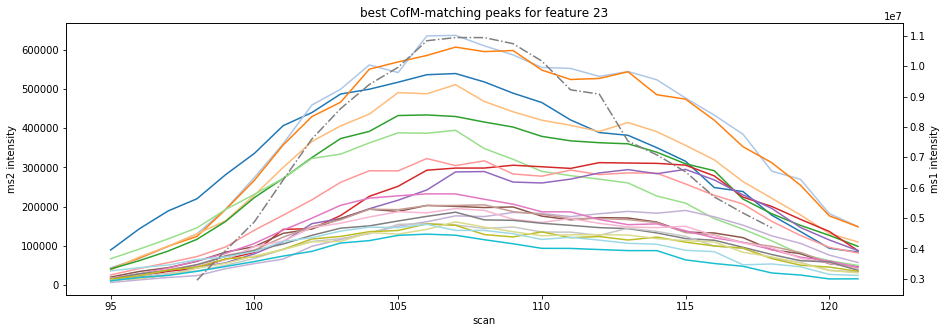

In [135]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
groups = ms2_peak_points_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax1.plot(group.scan, group.intensity, color=tableau20[i%len(tableau20)], label=name)
ax2.plot(base_peak_points_df.scan, base_peak_points_df.intensity, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax1.set_ylabel('ms2 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms1 intensity')
plt.title('best CofM-matching peaks for feature {}'.format(FEATURE_ID))
plt.margins(0.06)
plt.show()

In [154]:
# find the most intense ms2 peaks for this feature that match in centre-of-mass
db_conn = sqlite3.connect(DB_NAME)
peak_correlation_df = pd.read_sql_query("select * from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {}".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, 200), db_conn)
db_conn.close()

In [155]:
# get the ms2 peaks for the feature
db_conn = sqlite3.connect(DB_NAME)
ms2_peaks_df = pd.read_sql_query("select feature_id,peak_id,centroid_mz from ms2_peaks where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(FEATURE_ID, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, 200), db_conn)
db_conn.close()

In [156]:
ms2_peaks_df.head()

,feature_id,peak_id,centroid_mz
0,23,1,588.361
1,23,2,861.007
2,23,3,861.508
3,23,4,775.952
4,23,5,776.454


In [157]:
peak_correlation_df.head()

,feature_id,base_peak_id,ms1_scan_centroid,ms1_rt_centroid,ms2_peak_id,ms2_scan_centroid,ms2_rt_centroid,scan_distance,rt_distance,correlation
0,23,2,110.144302,1151.36315,1,107.403725,1151.336424,2.740577,0.026726,0.0
1,23,2,110.144302,1151.36315,2,108.975504,1151.332457,1.168798,0.030693,0.0
2,23,2,110.144302,1151.36315,3,108.986546,1151.332787,1.157756,0.030363,0.0
3,23,2,110.144302,1151.36315,4,108.607330,1151.335597,1.536972,0.027553,0.0
4,23,2,110.144302,1151.36315,5,108.514538,1151.333596,1.629764,0.029554,0.0


In [158]:
merged_ms2_peak_df = pd.merge(ms2_peaks_df, peak_correlation_df, left_on=['feature_id','peak_id'], right_on=['feature_id','ms2_peak_id'])

In [159]:
merged_ms2_peak_df.head()

,feature_id,peak_id,centroid_mz,base_peak_id,ms1_scan_centroid,ms1_rt_centroid,ms2_peak_id,ms2_scan_centroid,ms2_rt_centroid,scan_distance,rt_distance,correlation
0,23,1,588.361,2,110.144302,1151.36315,1,107.403725,1151.336424,2.740577,0.026726,0.0
1,23,2,861.007,2,110.144302,1151.36315,2,108.975504,1151.332457,1.168798,0.030693,0.0
2,23,3,861.508,2,110.144302,1151.36315,3,108.986546,1151.332787,1.157756,0.030363,0.0
3,23,4,775.952,2,110.144302,1151.36315,4,108.607330,1151.335597,1.536972,0.027553,0.0
4,23,5,776.454,2,110.144302,1151.36315,5,108.514538,1151.333596,1.629764,0.029554,0.0


In [146]:
z = np.polyfit(x=merged_ms2_peak_df.centroid_mz, y=merged_ms2_peak_df.scan_distance, deg=1)
p = np.poly1d(z)
merged_ms2_peak_df['trendline_scan'] = p(merged_ms2_peak_df.centroid_mz)

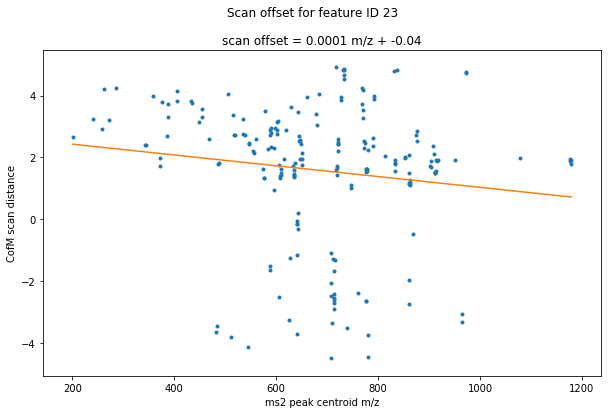

In [150]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.centroid_mz, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
merged_ms2_peak_df.set_index(merged_ms2_peak_df.centroid_mz, inplace=True)
merged_ms2_peak_df.trendline_scan.sort_index(ascending=False).plot(ax=ax1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('CofM scan distance')
plt.margins(0.06)
plt.suptitle('Scan offset for feature ID {}'.format(FEATURE_ID))
plt.title('scan offset = {0:.4f} m/z + {1:.2f}'.format(z[0],z[1]))
plt.show()

In [151]:
z = np.polyfit(x=merged_ms2_peak_df.centroid_mz, y=merged_ms2_peak_df.rt_distance, deg=1)
p = np.poly1d(z)
merged_ms2_peak_df['trendline_rt'] = p(merged_ms2_peak_df.centroid_mz)

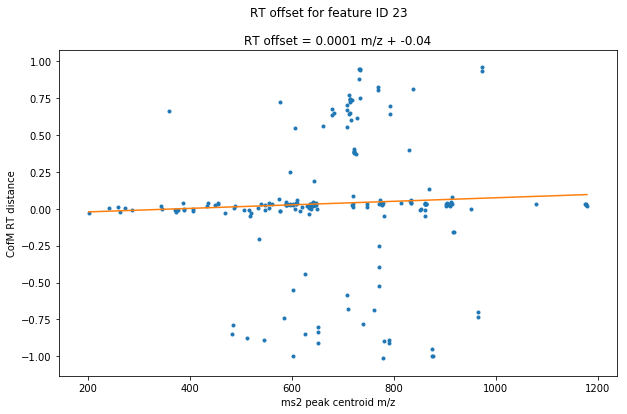

In [152]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.centroid_mz, merged_ms2_peak_df.rt_distance, marker='o', linestyle='', ms=3)
merged_ms2_peak_df.set_index(merged_ms2_peak_df.centroid_mz, inplace=True)
merged_ms2_peak_df.trendline_rt.sort_index(ascending=False).plot(ax=ax1)
plt.xlabel('ms2 peak centroid m/z')
plt.ylabel('CofM RT distance')
plt.margins(0.06)
plt.suptitle('RT offset for feature ID {}'.format(FEATURE_ID))
plt.title('RT offset = {0:.4f} m/z + {1:.2f}'.format(z[0],z[1]))
plt.show()

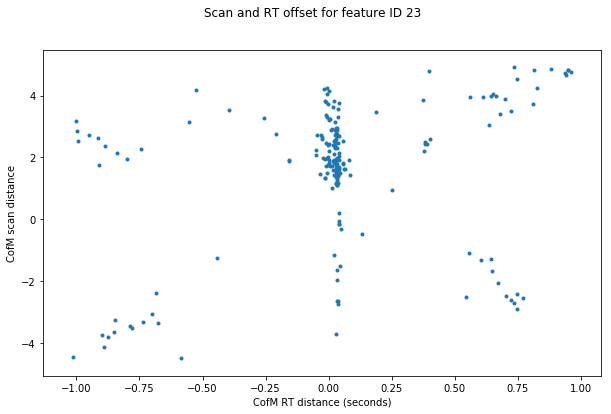

In [143]:
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax1.plot(merged_ms2_peak_df.rt_distance, merged_ms2_peak_df.scan_distance, marker='o', linestyle='', ms=3)
plt.xlabel('CofM RT distance (seconds)')
plt.ylabel('CofM scan distance')
plt.margins(0.06)
plt.suptitle('Scan and RT offset for feature ID {}'.format(FEATURE_ID))
plt.show()

Write out the top peaks for the top features

In [195]:
NUMBER_OF_TOP_FEATURES = 200
NUMBER_OF_TOP_PEAKS = 200

In [196]:
# get the 200 top-matching ms2 peaks for the top 200 features
db_conn = sqlite3.connect(CONV_DB_NAME)
top_features_df = pd.read_sql_query("select feature_id from features order by feature_id ASC limit {}".format(NUMBER_OF_TOP_FEATURES), db_conn)
db_conn.close()

In [203]:
import os

db_conn = sqlite3.connect(DB_NAME)
filename = "~/top_peaks.csv"
if os.path.isfile(filename):
    os.remove(filename)
    
for idx in range(len(top_features_df)):
    feature_id = top_features_df.loc[idx].feature_id
    print("feature ID {}".format(feature_id))
    df_1 = pd.read_sql_query("select feature_id,peak_id,centroid_mz from ms2_peaks where feature_id || '-' || peak_id in (select feature_id || '-' || ms2_peak_id from peak_correlation where feature_id == {} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {})".format(feature_id, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, NUMBER_OF_TOP_PEAKS), db_conn)
    df_2 = pd.read_sql_query("select * from peak_correlation where feature_id=={} and abs(rt_distance) <= {} and abs(scan_distance) <= {} order by ms2_peak_id limit {}".format(feature_id, MAX_RT_DISTANCE, MAX_SCAN_DISTANCE, NUMBER_OF_TOP_PEAKS), db_conn)
    df = pd.merge(df_1, df_2, left_on=['feature_id','peak_id'], right_on=['feature_id','ms2_peak_id'])
    df.drop(['peak_id','correlation'], inplace=True, axis=1)
    # write the CSV
    if os.path.isfile(filename):
        df.to_csv(filename, mode='a', sep=',', index=False, header=False)
    else:
        df.to_csv(filename, mode='a', sep=',', index=False, header=True)

db_conn.close()

feature ID 1
feature ID 2
feature ID 3
feature ID 4
feature ID 5
feature ID 6
feature ID 7
feature ID 8
feature ID 9
feature ID 10
feature ID 11
feature ID 12
feature ID 13
feature ID 14
feature ID 15
feature ID 16
feature ID 17
feature ID 18
feature ID 19
feature ID 20
feature ID 21
feature ID 22
feature ID 23
feature ID 24
feature ID 25
feature ID 26
feature ID 27
feature ID 28
feature ID 29
feature ID 30
feature ID 31
feature ID 32
feature ID 33
feature ID 34
feature ID 35
feature ID 36
feature ID 37
feature ID 38
feature ID 39
feature ID 40
feature ID 41
feature ID 42
feature ID 43
feature ID 44
feature ID 45
feature ID 46
feature ID 47
feature ID 48
feature ID 49
feature ID 50
feature ID 51
feature ID 52
feature ID 53
feature ID 54
feature ID 55
feature ID 56
feature ID 57
feature ID 58
feature ID 59
feature ID 60
feature ID 61
feature ID 62
feature ID 63
feature ID 64
feature ID 65
feature ID 66
feature ID 67
feature ID 68
feature ID 69
feature ID 70
feature ID 71
feature ID 72
f